# Notebook 01 — Problemverständnis, Datenbeschreibung & EDA (Anforderungen 1–3)

**Projekt:** Vorhersage der Fahrtdauer von Fahrradaktivitäten (Regression)  
**Target:** `moving_time` (Sekunden)

Dieses Notebook deckt die Anforderungen **1–3** ab:
1. **Problembeschreibung**
2. **Datenquelle & Datenbeschreibung**
3. **Explorative Datenanalyse (EDA)**

**Wichtige Abgrenzung:** In diesem Notebook wird **kein** Modell trainiert und **kein** Train/Test-Split durchgeführt. Ziel ist ein sauberes, nachvollziehbares Verständnis der Daten als Grundlage für die nächsten Schritte.

**Outputs dieses Notebooks**
- `data/processed/processed.csv` (bereinigte, homogenisierte Datengrundlage)
- `plots/` (alle Abbildungen, 300 dpi)
- `data_derived/` (EDA-Tabellen, z. B. Missingness, Korrelationsrankings, Cleaning-Report)


## Welche Fragen beantworten wir in diesem Notebook?

1. **Datengröße:** Wie groß ist der Datensatz (Zeilen/Spalten) — vor und nach Bereinigung?
2. **Spalten & Relevanz:** Welche Spalten gibt es, welche werden entfernt, welche bleiben für die weitere Analyse?
3. **Datentypen:** Welche Variablentypen liegen vor (numerisch/kategorisch/datetime)?
4. **Fehlende Werte:** Gibt es Missing Values — wenn ja, wo und in welchem Umfang?
5. **Verteilungen:** Wie sind die Verteilungen von Distanz, Höhenmetern und Dauer?
6. **Zusammenhänge:** Welche Features hängen mit dem Target `moving_time` zusammen (Korrelationen, Scatter-Plots)?
7. **Datenqualität:** Welche Ausreißer/Fehlmessungen verzerren die Daten und wie homogenisieren wir den Datensatz?


In [104]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Robust: Repo-Root erkennen (egal ob Start aus notebooks/ oder Root)
CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_RAW = REPO_ROOT / "data" / "raw" / "raw.csv"              # lokal, nicht versioniert
PATH_PROCESSED = REPO_ROOT / "data" / "processed" / "processed.csv"
PATH_PLOTS = REPO_ROOT / "plots"
PATH_DERIVED = REPO_ROOT / "data_derived"

PATH_PLOTS.mkdir(parents=True, exist_ok=True)
PATH_DERIVED.mkdir(parents=True, exist_ok=True)
PATH_PROCESSED.parent.mkdir(parents=True, exist_ok=True)

def savefig(filename: str) -> None:
    """Save current matplotlib figure consistently."""
    out = PATH_PLOTS / filename
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")


## Datenquelle und Lizenz (Anforderung 2)

Die Rohdaten wurden ursprünglich aus einem öffentlichen Datensatz von **Kaggle** bezogen:

- **Dataset:** *Outdoor cycling metrics*  
- **Kaggle Identifier:** `dorinaferencsik/outdoor-cycling-metrics`  
- **Link:** https://www.kaggle.com/datasets/dorinaferencsik/outdoor-cycling-metrics 

**Lizenzhinweis:** Die konkrete Lizenz wird auf der Kaggle-Datasetseite angegeben und sollte für die finale Projektdokumentation hier ergänzt werden (z. B. Lizenzname + Datum des Abrufs).

**Hinweis zur Datenhaltung im Repository**
- `data/raw/raw.csv` ist **nicht versioniert** (lokal, per `.gitignore` ausgeschlossen).
- Die in diesem Notebook erzeugte bereinigte Version `data/processed/processed.csv` ist die **Single Source of Truth** für alle folgenden Notebooks.


In [105]:
if not PATH_RAW.exists():
    raise FileNotFoundError(
        f"Raw file not found at: {PATH_RAW}\n"
        "Expected local file (not versioned). Please place raw.csv in data/raw/."
    )

df_raw = pd.read_csv(PATH_RAW)

# Parse datetime if present (robust)
if "start_date_local" in df_raw.columns:
    df_raw["start_date_local"] = pd.to_datetime(df_raw["start_date_local"], errors="coerce")

print("Raw dataset shape (rows, cols):", df_raw.shape)
print("\nColumns:")
print(df_raw.columns.tolist())

print("\nDtypes:")
display(df_raw.dtypes.to_frame("dtype"))


Raw dataset shape (rows, cols): (10158, 14)

Columns:
['hashed_id', 'age_group', 'gender', 'average_speed', 'distance', 'elapsed_time', 'highest_elevation', 'lowest_elevation', 'end_coordinates', 'max_speed', 'moving_time', 'start_date_local', 'start_coordinates', 'total_elevation_gain']

Dtypes:


,dtype
hashed_id,object
age_group,int64
gender,object
average_speed,float64
distance,float64
elapsed_time,int64
highest_elevation,float64
lowest_elevation,float64
end_coordinates,object
max_speed,float64


### Kurzbeschreibung der Variablen (Interpretation)

- `distance`: zurückgelegte Strecke (typischerweise **Meter**)
- `moving_time`: Fahrtdauer **ohne** Pausen (typischerweise **Sekunden**) → **Target**
- `elapsed_time`: verstrichene Zeit **inkl.** Pausen (typischerweise **Sekunden**)
- `total_elevation_gain`: aufsummierte Höhenzunahme (typischerweise **Meter**)
- `highest_elevation` / `lowest_elevation`: höchste/tiefste Höhe über NN (typischerweise **Meter**)

Die Einheiten werden im nächsten Schritt über Plausibilitätschecks (Wertebereiche) indirekt validiert.


## Problembeschreibung (Anforderung 1)

Ziel dieses Projekts ist die Entwicklung eines Regressionsmodells zur Vorhersage der Fahrtdauer einer Fahrradaktivität.  
Als Zielvariable wird `moving_time` verwendet (verstrichene Zeit **ohne** Pausen).

**Motivation / Nutzen**
- Zeitabschätzung für Touren (Planung, Erwartungsmanagement)
- Plausibilitätsprüfung und Qualitätssicherung von Aktivitätsdaten
- Grundlage für weiterführende Analysen (z. B. Belastung, Training, Routenvergleich)

**Herausforderungen / Risiken**
- **Ausreißer und Messfehler** (z. B. unrealistische Zeiten/Höhen) können Verteilungen und Korrelationen stark verzerren.
- Potenzielles **Leakage-Risiko**: `elapsed_time` ist inhaltlich nahe am Target (beide in Sekunden). Dieser Zusammenhang wird in der EDA explizit geprüft und später kritisch bewertet.
- Heterogenität der Aktivitäten (unterschiedliche Distanzen, Höhenprofile, Pausenverhalten) führt zu Nichtlinearitäten.


## Datenbereinigung und Homogenisierung (Anforderung 2 → Voraussetzung für Anforderung 3)

Um die Datenqualität zu erhöhen und die anschließende Exploration aussagekräftiger zu machen, wird der Datensatz **geframed**:

### (A) Irrelevante Spalten entfernen
Folgende Spalten werden nicht weiter berücksichtigt, da sie entweder nicht direkt zur Vorhersage beitragen oder unvollständig/anonymisiert sind:

`age_group`, `average_speed`, `max_speed`, `hashed_id`, `gender`, `start_coordinates`, `end_coordinates`, `start_date_local`

### (B) Filterregeln zur Ausreißer-Entfernung
- `elapsed_time` (Sekunden, inkl. Pause): **600 < value < 36.000**
- `moving_time` (Sekunden, exkl. Pause): **600 < value < 36.000**
- `highest_elevation` (m über NN): **value < 5.000**
- `lowest_elevation` (m über NN): **value > -430** (≈ tiefster Punkt der Erde)

**Ziel:** Ausschluss unrealistischer oder fehlerhafter Messungen → homogener, realistischer Datensatz.


In [106]:
# Start from raw
df = df_raw.copy()

rows_before = len(df)

# (A) Drop irrelevant columns
cols_drop = [
    "age_group", "average_speed", "max_speed", "hashed_id", "gender",
    "start_coordinates", "end_coordinates", "start_date_local"
]
cols_drop = [c for c in cols_drop if c in df.columns]
df = df.drop(columns=cols_drop)

# (B) Apply filter rules (keep report per rule)
report = []

def apply_filter(data: pd.DataFrame, mask: pd.Series, rule_name: str) -> pd.DataFrame:
    before = len(data)
    out = data.loc[mask].copy()
    after = len(out)
    report.append({
        "rule": rule_name,
        "rows_before": before,
        "rows_after": after,
        "rows_removed": before - after,
        "removed_pct": (before - after) / before * 100 if before > 0 else 0.0
    })
    return out

# elapsed_time: 600 < x < 36000
if "elapsed_time" in df.columns:
    df = apply_filter(df, df["elapsed_time"].between(600, 36000, inclusive="neither"),
                      "elapsed_time between (600, 36000)")

# moving_time: 600 < x < 36000
if "moving_time" in df.columns:
    df = apply_filter(df, df["moving_time"].between(600, 36000, inclusive="neither"),
                      "moving_time between (600, 36000)")

# highest_elevation: < 5000
if "highest_elevation" in df.columns:
    df = apply_filter(df, df["highest_elevation"] < 5000,
                      "highest_elevation < 5000")

# lowest_elevation: > -430
if "lowest_elevation" in df.columns:
    df = apply_filter(df, df["lowest_elevation"] > -430,
                      "lowest_elevation > -430")

rows_after = len(df)
removed = rows_before - rows_after
removed_pct = removed / rows_before * 100 if rows_before > 0 else 0.0

cleaning_report = pd.DataFrame(report)
display(cleaning_report)

# Save cleaning report
cleaning_report.to_csv(PATH_DERIVED / "00_cleaning_report.csv", index=False)

# Save processed dataset (single source of truth)
df.to_csv(PATH_PROCESSED, index=False)

print(f"Rows before cleaning: {rows_before}")
print(f"Rows after cleaning:  {rows_after}")
print(f"Removed: {removed} rows ({removed_pct:.2f}%)")
print(f"Saved processed dataset to: {PATH_PROCESSED}")


,rule,rows_before,rows_after,rows_removed,removed_pct
0,"elapsed_time between (600, 36000)",10158,9749,409,4.026383
1,"moving_time between (600, 36000)",9749,9651,98,1.005231
2,highest_elevation < 5000,9651,9494,157,1.626774
3,lowest_elevation > -430,9494,9492,2,0.021066


Rows before cleaning: 10158
Rows after cleaning:  9492
Removed: 666 rows (6.56%)
Saved processed dataset to: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/processed.csv


### Ergebnis der Bereinigung

Die Bereinigung reduziert den Datensatz von **`rows_before`** auf **`rows_after`** Beobachtungen.  
Dabei wurden **`removed`** Zeilen entfernt (**`removed_pct`**%), um Ausreißer und offensichtlich unrealistische Messungen auszuschließen.

Die bereinigte Datei `data/processed/processed.csv` dient ab jetzt als **Grundlage für die gesamte weitere Exploration und Modellierung**.


In [107]:
# Load processed as the official dataset for EDA
df = pd.read_csv(PATH_PROCESSED)

print("Processed dataset shape (rows, cols):", df.shape)
print("\nColumns (processed):")
print(df.columns.tolist())

summary_clean = pd.DataFrame([{
    "rows_before": rows_before,
    "rows_after": rows_after,
    "rows_removed": removed,
    "removed_pct": round(removed_pct, 2),
    "cols_removed": ", ".join(cols_drop),
}])

display(summary_clean)
summary_clean.to_csv(PATH_DERIVED / "01_rows_before_after_cleaning.csv", index=False)


Processed dataset shape (rows, cols): (9492, 6)

Columns (processed):
['distance', 'elapsed_time', 'highest_elevation', 'lowest_elevation', 'moving_time', 'total_elevation_gain']


,rows_before,rows_after,rows_removed,removed_pct,cols_removed
0,10158,9492,666,6.56,"age_group, average_speed, max_speed, hashed_id..."


## Explorative Datenanalyse (EDA) auf `processed.csv` (Anforderung 3)

Die EDA folgt einem klaren Ablauf:

1. **Data Quality Overview:** fehlende Werte, Duplikate, Datentypen
2. **Target-Analyse:** Verteilung von `moving_time`
3. **Feature-Verteilungen:** `distance`, `total_elevation_gain` (und optional weitere)
4. **Feature–Target-Zusammenhänge:** Scatter-Plots + Korrelationen
5. **Interpretation:** wichtigste Erkenntnisse als Grundlage für die nächsten Notebooks


,missing_share
distance,0.0
elapsed_time,0.0
highest_elevation,0.0
lowest_elevation,0.0
moving_time,0.0
total_elevation_gain,0.0


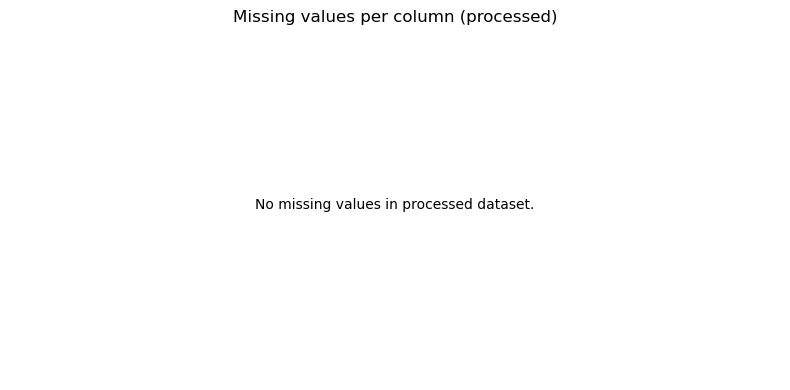

In [108]:
# Missing values (share per column)
missing_share = df.isna().mean().sort_values(ascending=False)

display(missing_share.to_frame("missing_share"))

# Save table
missing_share.to_frame("missing_share").to_csv(
    PATH_DERIVED / "02_missing_share_processed.csv", index=True
)

# Plot (robust if there are no missing values)
plt.figure(figsize=(8, 4))
ms_pos = missing_share[missing_share.gt(0)]

if ms_pos.empty:
    plt.title("Missing values per column (processed)")
    plt.text(0.5, 0.5, "No missing values in processed dataset.",
             ha="center", va="center")
    plt.axis("off")
else:
    ms_pos.plot(kind="bar")
    plt.ylabel("Missing share")
    plt.title("Missing values per column (processed)")

savefig("02_missing_values_bar_processed.png")
plt.show()


In [109]:
dup_count = df.duplicated().sum()
print(f"Duplicate rows in processed dataset: {dup_count}")

# Entscheidung: Duplikate entfernen (üblich) und dokumentieren
if dup_count > 0:
    df_before_dups = len(df)
    df = df.drop_duplicates().copy()
    df_after_dups = len(df)

    removed_dups = df_before_dups - df_after_dups
    print(f"Removed {removed_dups} duplicate rows. New shape: {df.shape}")

    # Save updated processed dataset (keeps 'processed.csv' as the single source of truth)
    df.to_csv(PATH_PROCESSED, index=False)
    print(f"Updated processed dataset saved to: {PATH_PROCESSED}")


Duplicate rows in processed dataset: 82
Removed 82 duplicate rows. New shape: (9410, 6)
Updated processed dataset saved to: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data/processed/processed.csv


### Data Quality — Kurzinterpretation

- **Fehlende Werte:** Die Missingness wird spaltenweise geprüft. Bei 0% fehlenden Werten ist der Datensatz diesbezüglich vollständig.
- **Duplikate:** Duplikate können Analysen verzerren (insbesondere bei Häufigkeiten und Korrelationen). Falls Duplikate vorhanden sind, werden sie entfernt und der bereinigte Stand erneut als `processed.csv` gespeichert.


## Verteilungen zentraler Variablen

Im nächsten Schritt werden die Verteilungen der wichtigsten Variablen analysiert:

- **Target:** `moving_time (s)`  
- **Feature 1:** `distance (m)`  
- **Feature 2:** `total_elevation_gain (m)`  

Ziel ist es, typische Wertebereiche, Schiefe sowie potenzielle verbleibende Ausreißer zu identifizieren.


In [110]:
vars_of_interest = ["moving_time", "distance", "total_elevation_gain", "elapsed_time",
                    "highest_elevation", "lowest_elevation"]
vars_of_interest = [c for c in vars_of_interest if c in df.columns]

desc = df[vars_of_interest].describe().T
desc["median"] = df[vars_of_interest].median()
display(desc)

desc.to_csv(PATH_DERIVED / "03_descriptive_stats_processed.csv", index=True)


,count,mean,std,min,25%,50%,75%,max,median
moving_time,9410.0,4522.091711,4403.021192,601.0,1474.0,2549.50,6330.00,33913.0,2549.50
distance,9410.0,26051.600106,26250.232727,0.0,7481.5,14754.95,35672.85,205882.0,14754.95
total_elevation_gain,9410.0,284.918140,421.097329,0.0,31.6,90.00,381.20,3896.8,90.00
elapsed_time,9410.0,5490.477790,5684.583054,601.0,1700.0,3206.50,7457.50,35990.0,3206.50
highest_elevation,9410.0,280.278215,190.757888,-71.2,163.0,229.60,305.15,2485.2,229.60
lowest_elevation,9410.0,132.162317,65.125857,-134.4,103.0,130.00,148.30,1484.0,130.00


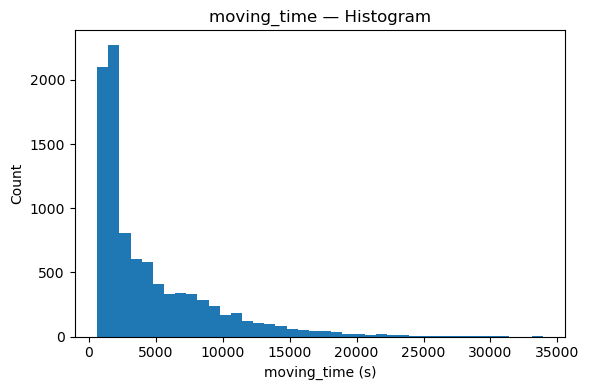

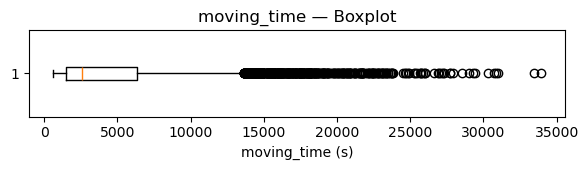

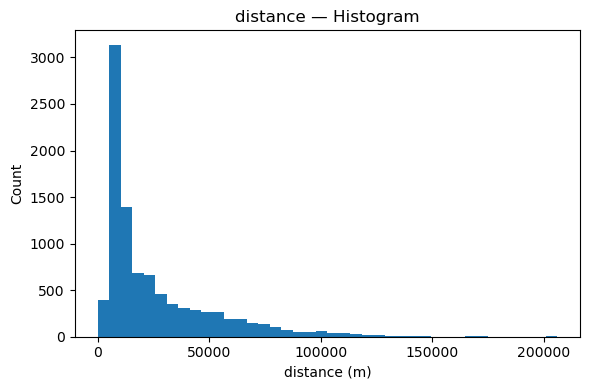

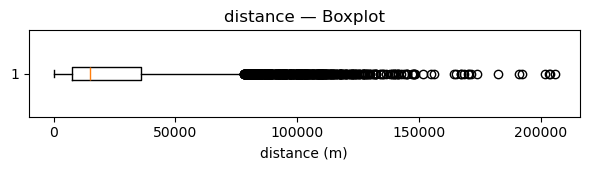

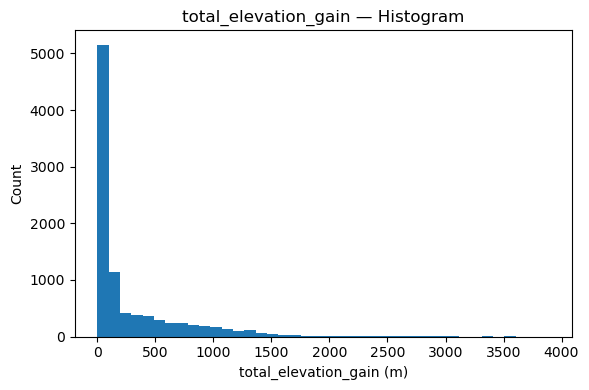

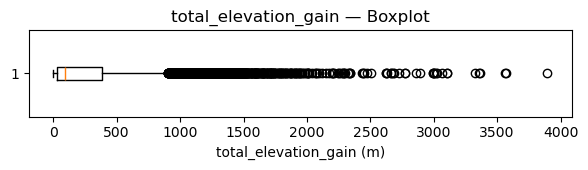

In [112]:
def hist_and_box(series: pd.Series, title: str, xlabel: str, fname_prefix: str) -> None:
    # Histogram
    plt.figure(figsize=(6, 4))
    plt.hist(series, bins=40)
    plt.title(f"{title} — Histogram")
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    savefig(f"{fname_prefix}_hist.png")
    plt.show()

    # Boxplot
    plt.figure(figsize=(6, 1.8))
    plt.boxplot(series, vert=False)
    plt.title(f"{title} — Boxplot")
    plt.xlabel(xlabel)
    savefig(f"{fname_prefix}_box.png")
    plt.show()

# Target
hist_and_box(df["moving_time"], "moving_time", "moving_time (s)", "03_moving_time")

# Feature: distance
hist_and_box(df["distance"], "distance", "distance (m)", "04_distance")

# Feature: total elevation gain
hist_and_box(df["total_elevation_gain"], "total_elevation_gain", "total_elevation_gain (m)", "05_total_elevation_gain")


## Feature–Target-Zusammenhänge

Zur Bewertung der Vorhersagerelevanz werden zentrale Features gegen das Target `moving_time` geplottet:

- `distance (m)` vs `moving_time (s)`
- `total_elevation_gain (m)` vs `moving_time (s)`
- `elapsed_time (s)` vs `moving_time (s)` (**Plausibilität & potenzielles Leakage**)

Hinweis: Eine **x=y**-Linie ist nur sinnvoll, wenn beide Achsen die gleiche Einheit bzw. die gleiche Größe beschreiben (z. B. `elapsed_time` und `moving_time`).


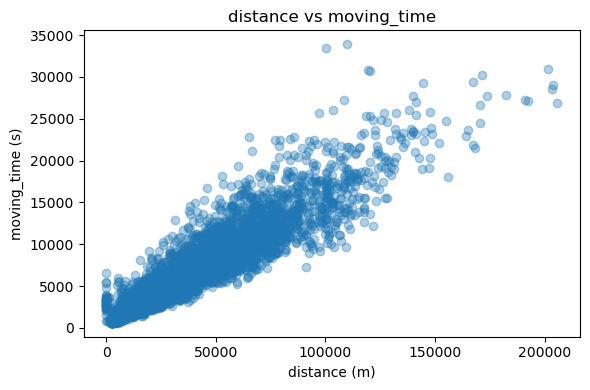

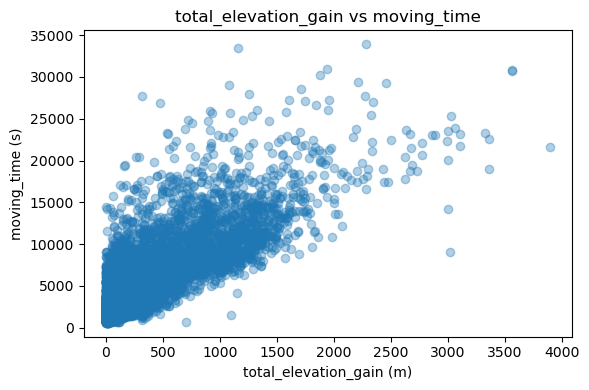

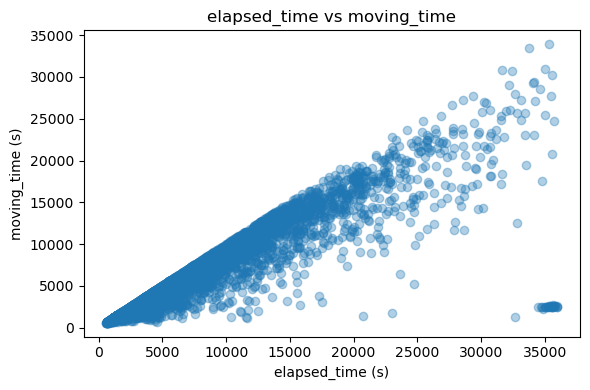

In [113]:
def scatter_xy(x: pd.Series, y: pd.Series, title: str, xlabel: str, ylabel: str, fname: str) -> None:
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.35)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    savefig(fname)
    plt.show()

scatter_xy(
    df["distance"], df["moving_time"],
    "distance vs moving_time",
    "distance (m)", "moving_time (s)",
    "06_distance_vs_moving_time.png"
)

scatter_xy(
    df["total_elevation_gain"], df["moving_time"],
    "total_elevation_gain vs moving_time",
    "total_elevation_gain (m)", "moving_time (s)",
    "07_elevation_gain_vs_moving_time.png"
)

scatter_xy(
    df["elapsed_time"], df["moving_time"],
    "elapsed_time vs moving_time",
    "elapsed_time (s)", "moving_time (s)",
    "08_elapsed_time_vs_moving_time.png"
)


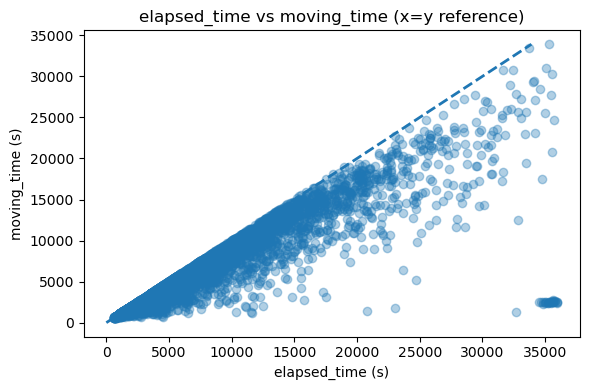

In [114]:
plt.figure(figsize=(6, 4))
plt.scatter(df["elapsed_time"], df["moving_time"], alpha=0.35)

m = min(df["elapsed_time"].max(), df["moving_time"].max())
plt.plot([0, m], [0, m], linestyle="--", linewidth=2)

plt.title("elapsed_time vs moving_time (x=y reference)")
plt.xlabel("elapsed_time (s)")
plt.ylabel("moving_time (s)")

savefig("09_elapsed_time_vs_moving_time_xy.png")
plt.show()


## Korrelationen (Überblick)

Zusätzlich zu den Scatter-Plots wird die lineare Korrelation (Pearson) zwischen den numerischen Variablen berechnet.

Ziel:
- schnelle Einschätzung, welche Features linear mit `moving_time` zusammenhängen
- Identifikation potenzieller **Leakage-Kandidaten** (sehr hohe Korrelation, inhaltlich nah am Target)


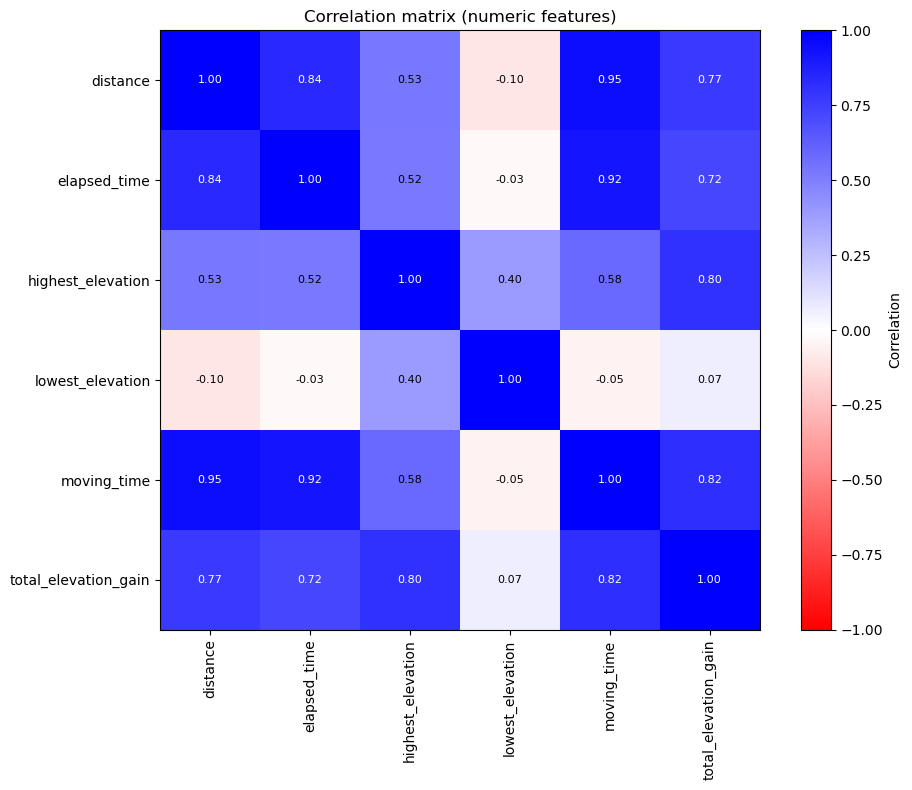

In [115]:
num = df.select_dtypes(include=[np.number])
corr = num.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 8))

# Clean diverging map: red -> white -> blue (0 = white)
im = ax.imshow(corr, cmap="bwr_r", vmin=-1, vmax=1)

ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index)

fig.colorbar(im, ax=ax, label="Correlation")

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        v = corr.iat[i, j]
        ax.text(j, i, f"{v:.2f}", ha="center", va="center",
                fontsize=8, color=("white" if abs(v) > 0.6 else "black"))

ax.set_title("Correlation matrix (numeric features)")
savefig("10_corr_matrix.png")
plt.show()


In [116]:
if "moving_time" in corr.columns:
    top_corr = corr["moving_time"].sort_values(key=lambda s: s.abs(), ascending=False)
    display(top_corr.to_frame("corr_with_moving_time").head(15))

    top_corr.to_frame("corr_with_moving_time").to_csv(
        PATH_DERIVED / "04_corr_with_target_processed.csv", index=True
    )


,corr_with_moving_time
moving_time,1.000000
distance,0.946841
elapsed_time,0.917856
total_elevation_gain,0.819366
highest_elevation,0.584388
lowest_elevation,-0.047912


## Interpretation der EDA-Ergebnisse

Die EDA zeigt konsistente und plausible Zusammenhänge:

- **`distance`** weist eine sehr starke positive Korrelation mit `moving_time` auf (≈ 0.95).  
  → Längere Strecken führen erwartbar zu längeren Fahrzeiten.

- **`total_elevation_gain`** korreliert ebenfalls stark mit `moving_time` (≈ 0.82).  
  → Mehr Höhenmeter erhöhen die Fahrtdauer, jedoch mit größerer Streuung (z. B. Fitness, Steigungsprofil, Pausen).

- **`elapsed_time`** ist sehr stark mit `moving_time` korreliert (≈ 0.92).  
  → Inhaltlich ist `elapsed_time` der “Zeit inkl. Pause”-Counter und somit sehr nah am Target.  
  → Dies ist ein potenzieller **Leakage-Kandidat** und muss im Modellierungs-Notebook kritisch behandelt werden (Vergleich: Modell mit vs. ohne `elapsed_time`).

- **`lowest_elevation`** zeigt praktisch keinen linearen Zusammenhang mit `moving_time` (≈ -0.05).  
  → Die absolute Höhe allein scheint wenig aussagekräftig; relevant ist eher die Höhenänderung (`total_elevation_gain`).


## Konsequenzen für das weitere Vorgehen

Aus den EDA-Erkenntnissen ergeben sich konkrete nächste Schritte:

1. **Feature-Set für die Modellierung (Baseline):**
   - `distance`, `total_elevation_gain`, `highest_elevation`, `lowest_elevation`
   - Target: `moving_time`

2. **Leakage-Check als Pflichtvergleich:**
   - Modell **ohne** `elapsed_time` (realistisches Vorhersageszenario)
   - Modell **mit** `elapsed_time` (Upper Bound / Plausibilitätskontrolle)
   → Der Unterschied in der Performance dient als Indikator, ob `elapsed_time` die Vorhersage “zu einfach” macht.

3. **Anomalieprüfung (aus Scatter `elapsed_time` vs `moving_time`):**
   - Es sind einzelne Punkte sichtbar, bei denen `elapsed_time` sehr groß ist, `moving_time` aber sehr klein erscheint.  
   → Diese Fälle werden im nächsten Notebook gezielt identifiziert und geprüft (mögliche Messfehler oder Sonderfälle).


In [117]:
# Identify suspicious cases: very large elapsed_time but very small moving_time
# (thresholds chosen to capture the visible bottom-right cluster)
suspect = df[(df["elapsed_time"] > 30000) & (df["moving_time"] < 5000)].copy()

print("Suspicious cases (elapsed_time > 30000 & moving_time < 5000):", len(suspect))
display(suspect.head(20))

suspect.to_csv(PATH_DERIVED / "05_suspect_elapsed_vs_moving.csv", index=False)


Suspicious cases (elapsed_time > 30000 & moving_time < 5000): 26


,distance,elapsed_time,highest_elevation,lowest_elevation,moving_time,total_elevation_gain
2920,5145.8,32682,143.6,121.5,1293,47.6
7845,14492.2,35667,231.0,148.4,2705,81.4
7846,14646.7,35519,230.8,148.4,2529,80.5
7847,14667.8,35549,230.1,148.4,2624,80.2
7853,14632.6,35210,228.8,148.3,2444,79.0
7854,14721.7,35464,229.9,148.4,2546,79.9
7855,14675.6,35782,229.3,148.3,2611,79.5
7856,14632.6,35213,228.8,148.3,2447,79.0
7857,14658.3,35990,230.7,148.4,2562,79.6
7859,14689.6,35730,231.5,148.4,2611,79.4
